In [1]:
import chess.pgn
import pandas as pd
import numpy as np
import pickle
import json

In [2]:
def json_to_dataframe(json_data):
    f = open(json_data)  
    data = json.load(f)  
    f.close()
    return pd.DataFrame.from_dict(data)

In [3]:
def get_data_of_interest(df, normalized=False):
    df["WhiteElo"] = pd.to_numeric(df["WhiteElo"])
    df["BlackElo"] = pd.to_numeric(df["BlackElo"])
    df['avg_elo'] = df[['WhiteElo', 'BlackElo']].mean(axis=1)
    df['diff_elo'] = df['WhiteElo'] - df['BlackElo']
    df["WhiteResult"] = df["Result"]
    df["WhiteResult"] = df["WhiteResult"].str.replace('1-0', '1')
    df["WhiteResult"] = df["WhiteResult"].str.replace('1/2-1/2', '0.5')
    df["WhiteResult"] = df["WhiteResult"].str.replace('0-1', '0')
    df["WhiteResult"] = pd.to_numeric(df_lic["WhiteResult"])
    df.drop(columns=['Result'], inplace=True)
    if normalized:
        #normalized_df_lic=(df_lic-df_lic.mean())/df_lic.std()
        normalized_df = (df_lic-df_lic.min())/(df_lic.max()-df_lic.min())
        return normalized_df
    else:
        return df

In [4]:
#from converter.pgn_data import PGNData

#pgn_data = PGNData("data\Lichess Elite Database\lichess_elite_2020-04.pgn")
#pgn_data.export()

In [5]:
data_chbs = r"data\join_data7.json"
data_lich = r"data\lichess_elite_2016-02.json"

In [6]:
df_full_data_lich = json_to_dataframe(data_lich)
df_full_data_lich
df_full_data_lich.groupby(['Event']).count()

,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,Opening,Termination,TimeControl,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff,moves,BlackTitle,WhiteTitle
Event,,,,,,,,,,,,,,,,,,,
Rated Blitz game,12913,12913,12913,12913,12913,12913,12913,12903,12913,12913,12913,12913,12913,12913,12913,12903,12913,1778,1756
Rated Classical game,236,236,236,236,236,236,236,235,236,236,236,236,236,236,236,235,236,9,7


In [7]:
df_lic = df_full_data_lich.loc[df_full_data_lich['Event']=='Rated Blitz game', ['Result','WhiteElo','BlackElo']]
df_lic = get_data_of_interest(df_lic, normalized=False)
df_lic

,WhiteElo,BlackElo,avg_elo,diff_elo,WhiteResult
0,2406,2217,2311.5,189,1.0
1,2418,2375,2396.5,43,0.5
2,2211,2415,2313.0,-204,1.0
3,2416,2532,2474.0,-116,0.5
4,2526,2420,2473.0,106,1.0
...,...,...,...,...,...
13144,2372,2407,2389.5,-35,1.0
13145,2212,2407,2309.5,-195,0.0
13146,2374,2406,2390.0,-32,0.0
13147,2254,2415,2334.5,-161,0.0


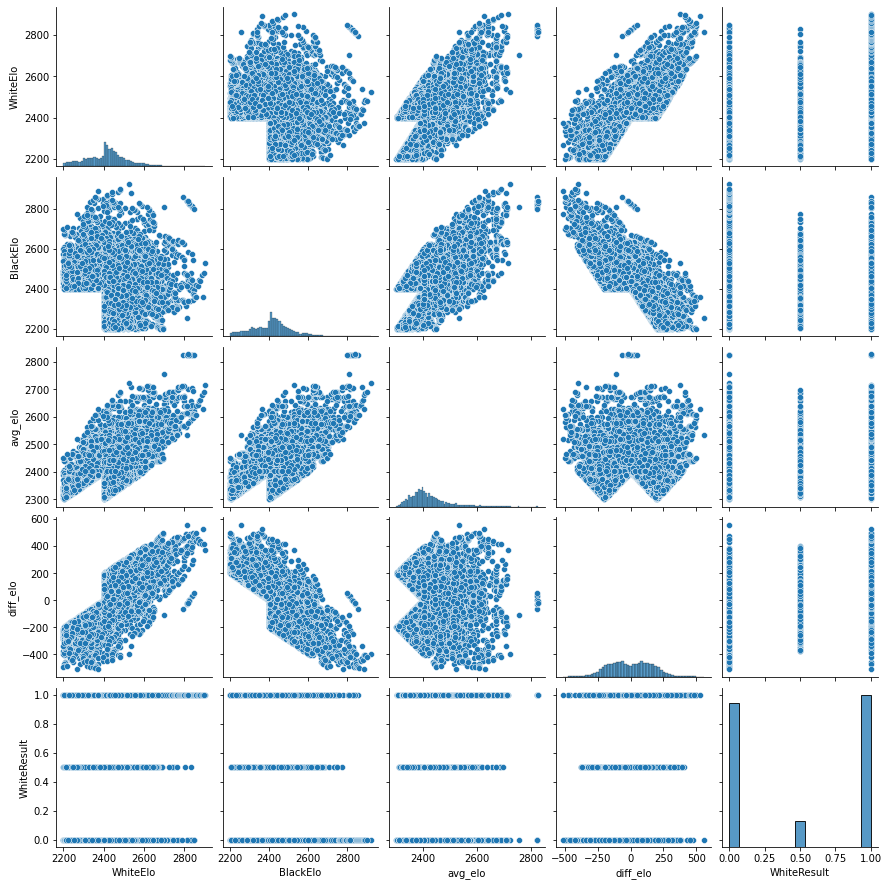

In [8]:
import seaborn as sns
sns.pairplot(df_lic)

In [9]:
df_lic.corr()['WhiteResult'].sort_values()

BlackElo      -0.298928
avg_elo       -0.001829
WhiteElo       0.296834
diff_elo       0.388790
WhiteResult    1.000000
Name: WhiteResult, dtype: float64

In [10]:
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

#X, y = normalized_df_lic[['WhiteElo',	'BlackElo',	'avg_elo',	'diff_elo']], df_lic[['WhiteResult']]
X, y = df_lic[['avg_elo','diff_elo']], df_lic[['WhiteResult']]


In [11]:
# define model
model = XGBRegressor()
# fit model
model.fit(X, y)

id = 2
yhat = model.predict(np.asarray(X.loc[[id]]))
print(yhat, y.loc[id])

[0.7590096] WhiteResult    1.0
Name: 2, dtype: float64


In [12]:
model.feature_importances_

array([0.2997162 , 0.70028377], dtype=float32)

In [13]:
yhat = y.copy()
for index, row in X.iterrows():
    yhat.loc[index] = model.predict(np.asarray(X.loc[[index]]))

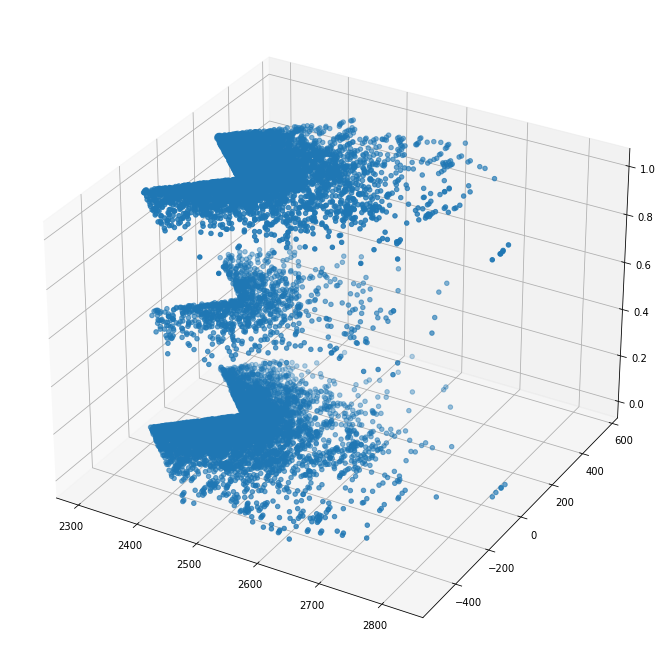

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X['avg_elo'], X['diff_elo'], y)
plt.show()

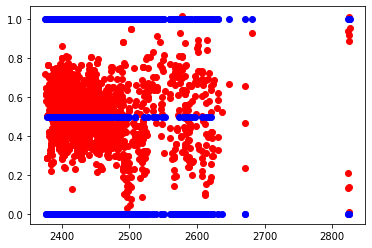

In [15]:
plt.plot(X[abs(X['diff_elo'])<50].avg_elo, yhat[abs(X['diff_elo'])<50].WhiteResult, 'ro')
plt.plot(X[abs(X['diff_elo'])<50].avg_elo, y[abs(X['diff_elo'])<50].WhiteResult, 'bo')

In [16]:
X['diff_elo'].min() #-513
X['diff_elo'].max() #559
X['avg_elo'].min() #2300.5
X['avg_elo'].max() #2826.0

2826.0

In [29]:
data = []
X_diff_elo=[]
X_avg_elo=[]
a=np.linspace(X['diff_elo'].min(), X['diff_elo'].max(), num=20)
b=np.linspace(X['avg_elo'].min(), X['avg_elo'].max(), num=20)
for diff_elo_i in range(0,len(a)-1):
    diff= (a[diff_elo_i]+a[diff_elo_i+1])/2
    #X_diff_elo.append(diff)
    for avg_elo_i in range(0,len(b)-1):
        avg=(b[avg_elo_i]+b[avg_elo_i+1])/2
        #X_avg_elo.append(avg)
        yy= y[(X['diff_elo']>=a[diff_elo_i]) & (X['diff_elo']<a[diff_elo_i+1]) & 
              (X['avg_elo']>=b[avg_elo_i]) & (X['avg_elo']<b[avg_elo_i+1])].values.mean()
        yyhat= yhat[(X['diff_elo']>=a[diff_elo_i]) & (X['diff_elo']<a[diff_elo_i+1]) & 
              (X['avg_elo']>=b[avg_elo_i]) & (X['avg_elo']<b[avg_elo_i+1])].values.mean()
        data.append([diff, avg, yy, yyhat])
df = pd.DataFrame(data, columns=['diff_elo','avg_elo','real','modeled']).round(decimals=2)
df

C:\Users\Giorgio\AppData\Local\Temp\ipykernel_14768\1871535772.py:13: RuntimeWarning: Mean of empty slice.
  (X['avg_elo']>=b[avg_elo_i]) & (X['avg_elo']<b[avg_elo_i+1])].values.mean()
C:\Users\Giorgio\anaconda3\envs\myenv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Giorgio\AppData\Local\Temp\ipykernel_14768\1871535772.py:15: RuntimeWarning: Mean of empty slice.
  (X['avg_elo']>=b[avg_elo_i]) & (X['avg_elo']<b[avg_elo_i+1])].values.mean()


,diff_elo,avg_elo,real,modeled
0,-484.79,2314.33,NaN,NaN
1,-484.79,2341.99,NaN,NaN
2,-484.79,2369.64,NaN,NaN
3,-484.79,2397.30,NaN,NaN
4,-484.79,2424.96,NaN,NaN
...,...,...,...,...
356,530.79,2701.54,NaN,NaN
357,530.79,2729.20,NaN,NaN
358,530.79,2756.86,NaN,NaN
359,530.79,2784.51,NaN,NaN


In [30]:
df[abs(df.modeled-0.5)<0.05]

,diff_elo,avg_elo,real,modeled
106,-202.68,2618.57,0.67,0.51
124,-146.26,2590.91,0.61,0.46
146,-89.84,2673.88,0.50,0.48
147,-89.84,2701.54,0.50,0.50
154,-33.42,2369.64,0.52,0.51
155,-33.42,2397.30,0.47,0.48
156,-33.42,2424.96,0.45,0.45
157,-33.42,2452.62,0.51,0.50
161,-33.42,2563.25,0.45,0.46
162,-33.42,2590.91,0.58,0.54


In [24]:
df_lic.loc[38]

WhiteElo       2593.0
BlackElo       2230.0
avg_elo        2411.5
diff_elo        363.0
WhiteResult       1.0
Name: 38, dtype: float64

In [32]:
b

array([2300.5       , 2328.15789474, 2355.81578947, 2383.47368421,
       2411.13157895, 2438.78947368, 2466.44736842, 2494.10526316,
       2521.76315789, 2549.42105263, 2577.07894737, 2604.73684211,
       2632.39473684, 2660.05263158, 2687.71052632, 2715.36842105,
       2743.02631579, 2770.68421053, 2798.34210526, 2826.        ])

In [33]:
max(2,3)

3